# Droite d'étalonnage

In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import t
from packaging import version

etalonnage = np.array([2 , 130,254,392,511,624,3,130,255,387,509,625])
gamme =np.array([0 , 0.5 , 1, 1.5,2,2.5,0 , 0.5 , 1, 1.5,2,2.5])
x_i = gamme
y_i = etalonnage

# Question 1,2

## Méthode automatique

a : 250.57142857142856 u_a 1.8674439586710003
b : 5.285714285714334 u_b 2.826983681363738


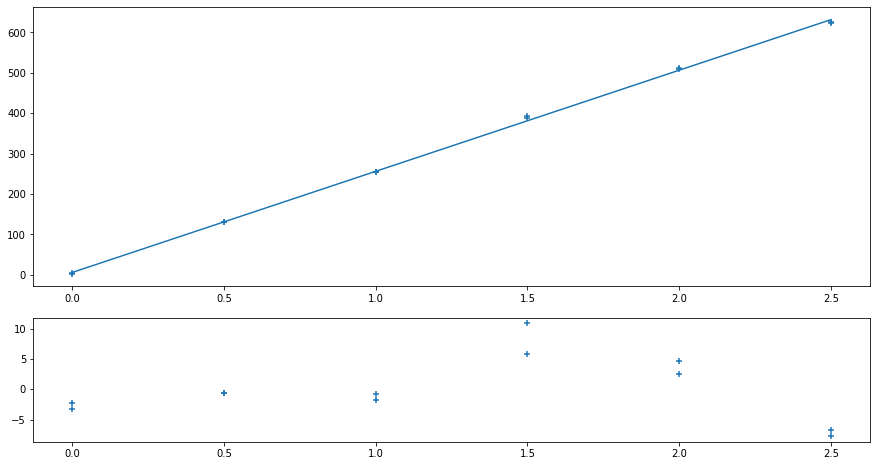

In [2]:
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(3, 1,hspace=0.25)

#droite
ax1 = fig.add_subplot(gs[0:2,0])
#points expérimentaux
ax1.scatter(gamme,etalonnage,marker='+')
#modélisation par une droite affine
coeffs = np.polyfit(gamme,etalonnage,1) #plus basique mais peut-être connu
coeffs2 = stats.linregress(gamme,etalonnage) #plus sophistiqué mais plus complet
a,b,r,p,ua=coeffs2

#on affiche l'incertitude sur l'ordonnée à l'origine uniquement pour les versions pas trop vieilles de scipy
if version.parse(scipy. __version__) > version.parse('1.6') :
    #il manque l'incertitude sur l'ordonnée à l'origine pour les versions de scipy inférieures à 1.6
    ub=coeffs2.intercept_stderr
    print('a : {} u_a {}\nb : {} u_b {}'.format(a,ua,b,ub))
else:
    print('a : {} u_a {}\nb : {} '.format(a,ua,b))


#tracé de la droite correspondant à la modélisation
xs = np.linspace(np.min(gamme),np.max(gamme),2)
ys = np.polyval(coeffs,xs)
ax1.plot(xs,ys)

#résidus
ax2 = fig.add_subplot(gs[2,0])
ax2.scatter(gamme,etalonnage-np.polyval(coeffs,gamme),marker='+')


## Méthode manuelle

In [3]:
#Formule 6.11
u_yi = np.std(y_i-a*x_i-b,ddof=2)

#Formule 6.8
upDelta = np.var(x_i)*x_i.size**2

#Formule 6.12
ua_man = np.sqrt( u_yi**2 /(np.var(x_i)*x_i.size) ) 
# u_yi*np.sqrt( x_i.size/upDelta )

#Formule 6.13
ub_man = np.sqrt( u_yi**2 *np.sum(x_i**2)/(np.var(x_i)*x_i.size**2) ) 
# u_yi*np.sqrt(np.sum(x_i**2)/upDelta )

print('a : {} u_a {}\nb : {} u_b {}'.format(a,ua_man,b,ub_man))

a : 250.57142857142856 u_a 1.8674439586706455
b : 5.285714285714334 u_b 2.8269836813632008


# Question 3

In [4]:
intervalle = 0.95
student = t.interval(intervalle,x_i.size-2)
print('coefficient de student {:.2f}'.format(student[1]))
print('b = {:.0f}±{:.0f} ({:.0f}%)'.format(b,ub*student[1],intervalle*100))

coefficient de student 2.23
b = 5±6 (95%)


# Question 4

In [5]:
#régression linéaire au lieu d'avoir une régression affine
gamme2=gamme[:,np.newaxis]
coefflin=np.linalg.lstsq(gamme2,etalonnage,rcond=None)
abis = coefflin[0][0]
#print(coefflin)

#Formule 6 du TD, 
# coefflin[1][0] = np.square(y_i-a*x_i).sum()
u_yi = np.sqrt(coefflin[1][0]/(x_i.size-1))
u_abis = u_yi*np.sqrt( np.sum(x_i**2)/(np.sum(x_i**2)**2) )

print('a : {} u_a {}'.format(abis,u_abis))
print('u_y : {}'.format(u_yi))

a : 253.4545454545455 u_a 1.1667829357826804
u_y : 6.118661334714105


# Question 5

In [6]:
Uis = np.array([484,481,484,483,483,481])
#U_0
U0 = np.average(Uis)
sigU = np.std(Uis,ddof=1)
sigU0 = sigU/np.sqrt(Uis.size)
print('U0 : {:.2f}, u_U : {:.2f}, u_U0 : {:.2f}'.format(U0,sigU,sigU0))

U0 : 482.67, u_U : 1.37, u_U0 : 0.56


# Question 6

In [7]:
C1 = U0/abis
urelC1 = np.sqrt((sigU0/U0)**2+(u_abis/abis)**2)
print('C_1 : {:.3e}, u_C1/C_1 : {:.3e}, u_C1 : {:.3e}'.format(C1,urelC1,urelC1*C1))


C_1 : 1.904e+00, u_C1/C_1 : 4.746e-03, u_C1 : 9.039e-03


# Question 7

In [8]:
urelU0 = sigU0/U0
urela = u_abis/abis


deglib = urelC1**4/(1/5*urelU0**4+1/11*urela**4)
print('nb de degré de liberté effectif : {}'.format(np.floor(deglib)))
texp = t.interval(intervalle,np.floor(deglib))[1]
print('coefficient de student {:.2f}'.format(texp))
UC1 = texp * urelC1*C1
print('C1 = {:.2f}±{:.2f} mg/L ({:.0f}%)'.format(C1,UC1,intervalle*100))


nb de degré de liberté effectif : 12.0
coefficient de student 2.18
C1 = 1.90±0.02 mg/L (95%)


# Question 8

In [9]:
C0 = 1000*C1
urelC0 = np.sqrt(urelC1**2+(0.1/(100*np.sqrt(3)))**2+(0.4/(1000*np.sqrt(3)))**2+2*(0.02/(10*np.sqrt(3)))**2)

print('u_C0/C_0 : {:.3e}'.format(urelC0))
uC0 = C0*urelC0
print('u_C0 : {:.3e}'.format(uC0))
UC0 = texp * uC0
print('C0 = {:.2f}±{:.2f} ({:.0f}%) mg/L'.format(C0,UC0,intervalle*100))


u_C0/C_0 : 5.058e-03
u_C0 : 9.632e+00
C0 = 1904.35±20.99 (95%) mg/L


# Méthode des ajouts dosés
## Question 10

In [10]:
upDeltaC = 1e-2 / 20
print('ΔC: {} g/L'.format(upDeltaC))

ΔC: 0.0005 g/L


## Question 11

a : 106.900 u_a 4.871
b : 300.200 u_b 11.932


Text(0.5, 1.0, 'Résidus')

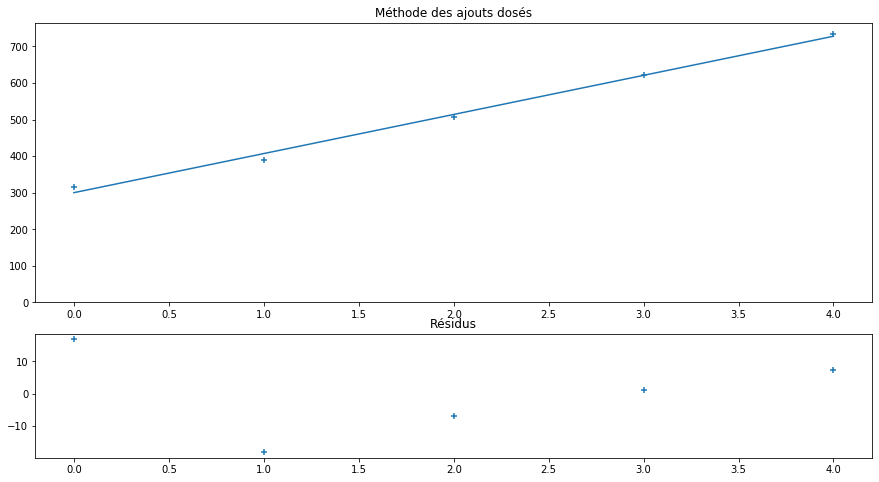

In [11]:
x_i = np.arange(5)
y_i = np.array([317,389,507,622,735])
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(3, 1,hspace=0.25)

#droite
ax1 = fig.add_subplot(gs[0:2,0])
#points expérimentaux
ax1.scatter(x_i,y_i,marker='+')
#modélisation par une droite affine
coeffs = np.polyfit(x_i,y_i,1)
coeffs2 = stats.linregress(x_i,y_i)
a,b,r,p,ua=coeffs2

#on affiche l'incertitude sur l'ordonnée à l'origine uniquement pour les versions pas trop vieilles de scipy
if version.parse(scipy. __version__) > version.parse('1.6') :
    #il manque l'incertitude sur l'ordonnée à l'origine pour les versions de scipy inférieures à 1.6
    ub=coeffs2.intercept_stderr
    print('a : {:.3f} u_a {:.3f}\nb : {:.3f} u_b {:.3f}'.format(a,ua,b,ub))
else:
    print('a : {:.3f} u_a {:.3f}\nb : {:.3f} '.format(a,ua,b))


#tracé de la droite correspondant à la modélisation
xs = np.linspace(np.min(x_i),np.max(x_i),2)
ys = np.polyval(coeffs,xs)
ax1.plot(xs,ys)
ax1.set_ylim(0,1.05*np.max(ys))
ax1.set_title('Méthode des ajouts dosés')
#résidus
ax2 = fig.add_subplot(gs[2,0])
ax2.scatter(x_i,y_i-np.polyval(coeffs,x_i),marker='+')
ax2.set_title('Résidus')

# Question 12

In [12]:
j0= b/a
print('j0 : {:.3f}'.format(j0))
CS2 = 20*j0*upDeltaC
print('CS2: {:.3e} g/L'.format(CS2))
CS0 = 100*CS2
print('CS0: {:.3f} g/L'.format(CS0))

j0 : 2.808
CS2: 2.808e-02 g/L
CS0: 2.808 g/L


# Question 13

In [13]:
#incertitude absolue sur la fiole de 100mL
u_v100=0.1/np.sqrt(3)
print(u_v100)

0.05773502691896258


In [14]:
#incertitude absolue sur le volume de S2/S3 (pipette de 5mL)
u_VS2=0.015/np.sqrt(3)
print(u_VS2)

0.008660254037844387


In [15]:
#formule explicite pour 6.11
u_Ui=np.sqrt(1/(y_i.size-2)* np.square(y_i-a*x_i-b).sum() )
print(u_Ui)
#formule équivalente dans ce cas
u_Ui=np.std(y_i-a*x_i-b,ddof=2)
print(u_Ui)

15.404544783926582
15.404544783926582


In [16]:
#incertitude sur la valeur moyenne de U_i pour les différents points
u_moyUi = 1/np.sqrt(5)*u_Ui
print(u_moyUi)

6.889121859859929


In [17]:
u_CS2 = np.sqrt(2*(CS2*u_VS2/5)**2+(20*0.5e-3/a*u_moyUi)**2+(20/(a**2)*0.5e-3*514*ua)**2 ) 
print('u_CS2 : {}'.format(u_CS2))

print('aaaaaaa')
#Contribution de l'incertitude sur les volumes prélevés à la fiole
print('pipettes {}'.format(2*(CS2*u_VS2/5)**2))
#Contribution de l'incertitude sur la valeur moyenne de la gamme
print('moyenne {}'.format((20*0.5e-3/a*u_moyUi)**2))
#Contribution de l'incertitude sur la pente
print('pente {}'.format((20/(a**2)*0.5e-3*514*ua)**2))
#incertitude au carré
print('total {}'.format(u_CS2**2))
print('aaaaa')
urel_CS2=u_CS2/CS2
print('u_CS2/C_S2 : {}'.format(urel_CS2))

u_CS2 : 0.0022849150030143533
aaaaaaa
pipettes 4.731700154275478e-09
moyenne 4.153099379485293e-07
pente 4.800794932897277e-06
total 5.220836571000082e-06
aaaaa
u_CS2/C_S2 : 0.08136489467762638


In [18]:
urel_CS0 = np.sqrt(urel_CS2**2+(0.4/(1000*np.sqrt(3)))**2+(0.02/(10*np.sqrt(3)))**2)
print('u_CS0/C_S0: {}'.format(urel_CS0))
u_CS0 = urel_CS0*CS0
print('u_CS0: {}'.format(u_CS0))

u_CS0/C_S0: 0.08137341551494505
u_CS0: 0.22851542878939668


# Question 14

In [19]:
taj = t.interval(0.95,3)[1]
print('cofficient de student : {}'.format(taj))

cofficient de student : 3.182446305284263


In [20]:
UCS0 = u_CS0*taj
print('C_S0 = {:.1f}±{:.1f} g/L ({:.0f}%)'.format(CS0,UCS0,intervalle*100))


C_S0 = 2.8±0.7 g/L (95%)
